# From Invoke to Stream
* Streaming provides several ways to visualize the output of a LangGraph app.

## Invoke vs. Stream

In LangGraph, the difference between `graph.invoke` and `graph.stream` lies in how they handle the **flow of execution** and **results** when working with nodes in a computational graph.

#### 1. **`graph.invoke`**:
   - **Purpose**: Executes the graph **all at once** and returns the **final result**.
   - **Behavior**:
     - It runs all the necessary nodes to compute the output.
     - The computation is **synchronous**, meaning you wait until the graph completes its entire process.
   - **Use Case**: When you need the **final output** of a graph and do not care about intermediate steps or streaming.

   **Example**: 
   If you have a graph that takes input data, processes it through several nodes, and produces a summary, `graph.invoke` will:
     - Execute the entire graph.
     - Return the final summary as a single result.


#### 2. **`graph.stream`**:
   - **Purpose**: Executes the graph **incrementally**, providing intermediate outputs or updates as the graph processes.
   - **Behavior**:
     - It allows you to observe the **output of nodes as they complete**, rather than waiting for the whole graph to finish.
     - Ideal for **real-time** or **progressive updates**.
   - **Use Case**: When you want to monitor or act on **intermediate results** as they are produced.

   **Example**: 
   If the graph is analyzing data in chunks, `graph.stream` will:
     - Provide you with intermediate outputs for each chunk as they are processed.
     - Let you handle or display results progressively, without waiting for the entire process to finish.


#### **Summary**:
- **`graph.invoke`**: Think of it as "Run the entire process and give me the final result."
- **`graph.stream`**: Think of it as "Run the process step-by-step and let me see results as they happen."

Which one you choose depends on whether you need the entire result at once (`invoke`) or prefer to receive updates during the process (`stream`).

## The importance of Stream in LangGraph: a few hints
You can grasp the importance of .stream in LangGraph by taking a look at the following concepts:

#### **1. What is a step in LangGraph?**

- A **step** is like a moment in the app's execution where some work is done.
- Usually, each **node** in the graph represents a separate step because it performs a task.
- However, if multiple nodes are set up to run **at the same time (in parallel)**, they all belong to the **same step** because they execute together.
- **Key note**: The LangGraph team sometimes uses the terms **"step"** and **"checkpoint"** interchangeably, so consider them as meaning the same thing.

#### **2. How can we see what is in the state of an app in LangGraph?**

- The **state** is like a snapshot of everything the app knows or has done up to a certain step.
  - **`graph.get_state()`**:
    - Gives you the **current state** (what’s happening right now or what just finished).
    - It shows what the app knows at the **latest step**.
  - **`graph.get_state_history()`**:
    - Provides a **list of all past states**.
    - This is like a timeline that shows how the app progressed through each step.

#### **3. How can we execute an app starting from different steps in LangGraph?**

- You can control where the app starts processing by specifying the **step**.
  - **`graph.stream(None, {thread_id})`**:
    - Starts the app from the **most recent step** (the latest state).
    - Useful if you just want to continue from where the app left off.
  - **`graph.stream(None, {particular_step, thread_id})`**:
    - Starts the app from a **specific step** you choose.
    - Useful if you want to retry or re-execute from an earlier point in the graph’s timeline.

#### **Analogy**:

Imagine you're reading a book:
- A **step** is like a chapter in the book.
  - Most chapters (nodes) are read one at a time, but some chapters (parallel nodes) are read simultaneously.
- **`graph.get_state()`**: Tells you the current chapter you’re reading.
- **`graph.get_state_history()`**: Gives you a summary of all the chapters you've read so far.
- **`graph.stream(None, {thread_id})`**: Continues reading from the last chapter.
- **`graph.stream(None, {particular_step, thread_id})`**: Lets you jump back and reread a specific chapter before continuing.

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 015-streaming.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]
os.environ["http_proxy"] = ""
os.environ["https_proxy"] = ""

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [2]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## Streaming
* Let's see various ways to stream outputs from a LangGraph app.
* We will start by reusing the logic of our previous app.
* **Note that the LangGraph team includes RunnableConfig with call_model to enable token-wise streaming. This is only needed with python < 3.11.**

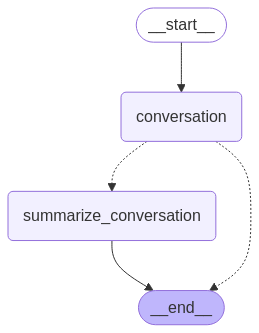

In [3]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## LangGraph supports different streaming modes for graph state
In LangGraph, when using `stream_mode`, the option defines **what kind of information** you receive while the graph is running. Here's the difference between `"updates"` and `"values"`:

#### **1. `stream_mode="updates"`**
- **What it does**: Sends updates about the **state of the graph**.
- **What you get**:
  - Notifications when nodes are **starting**, **in progress**, or **completed**.
  - It’s like getting a progress report about **what is happening** in the graph.
- **Use Case**:
  - Use this if you want to monitor the graph's activity or **debug** its execution.
  - Example: "Node A has started processing," "Node B has finished."

#### **2. `stream_mode="values"`**
- **What it does**: Sends the **actual outputs** of the nodes as they are computed.
- **What you get**:
  - The **data or results** produced by the nodes as they finish their work.
  - It’s like receiving the intermediate or final **answers** the graph is producing.
- **Use Case**:
  - Use this if you need the **results** from the nodes as soon as they are available.
  - Example: "Node A produced value X," "Node B produced value Y."

#### **Key Difference**:
- `"updates"`: Focuses on **what the graph is doing** (progress updates).
- `"values"`: Focuses on **what the graph is producing** (data outputs).

#### **Simple Analogy**:
Imagine you’re baking a cake:
- **`stream_mode="updates"`**: You get messages like, "The oven is preheating," "The batter is in the oven," "The cake is done."
- **`stream_mode="values"`**: You get tastes of the batter, frosting, and cake as they are made, showing the **results** of each step.

Choose `"updates"` to track **activity** and `"values"` to track **results**.

## You will understand it easier looking at the following image
* stream_mode="updates": This streams only the updates to the state after each node is called.
* stream_mode="values": This streams the full state after each node is called.

![Simple graph](graph004.png)

## Differences between the "values" and "updates" modes in LangGraph Streaming

LangGraph provides two main modes for streaming outputs during a graph run: **"values"** and **"updates"**. These modes differ in how they handle and deliver state information after each step of the graph. Here's a simplified explanation:

#### **1. The "values" Mode**  
- **What it does:**  
  - Streams the **entire state** of the graph **after each step** is completed.  
  - The state reflects **all updates** made up to that point, providing a **snapshot** of the graph's progress.  

- **Key Characteristic:**  
  - You get the **full picture** of the current state, including any unchanged values carried forward.  

- **Use Case Examples:**  
  1. **Progress Tracking:**  
     - Monitor how the overall state evolves after each step.  
  2. **Debugging and Logging:**  
     - Useful for reviewing the entire context if something goes wrong.  
  3. **Final State Validation:**  
     - Ensures you can verify the full data structure after any step to catch unexpected changes.  

#### **2. The "updates" Mode**  
- **What it does:**  
  - Streams **only the changes (updates)** made to the state during a step.  
  - If multiple updates occur in the same step (e.g., multiple nodes are executed), each update is streamed **individually**.  

- **Key Characteristic:**  
  - Focuses on **just the changes** made, rather than the full state.  

- **Use Case Examples:**  
  1. **Incremental Feedback:**  
     - Ideal for real-time systems where you need **partial results** as soon as they're available (e.g., chatbots).  
  2. **Efficiency for Large States:**  
     - Avoids resending unchanged parts of the state, making it **faster and lighter** for large graphs.  
  3. **Interactive Applications:**  
     - Great for applications requiring **continuous updates**, such as form filling or dynamic visualizations.  

#### **Summary Table**

| Feature       | "values" Mode                             | "updates" Mode                           |
|---------------|-------------------------------------------|------------------------------------------|
| **Streams**   | Full state after each step                | Only changes (updates) after each step   |
| **Granularity**| High-level (full snapshot)               | Low-level (incremental updates)         |
| **Best for**  | Debugging, progress tracking, final checks| Real-time feedback, interactive apps, efficiency |

Both modes are designed to handle different needs depending on whether you prefer **complete snapshots** or **incremental updates**.

## Streaming only the updates to the state with stream_mode="updates"

In [4]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream(
    {"messages": [HumanMessage(content="Hi! I'm Julio")]}, 
    config, 
    stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hello, Julio! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 11, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6ec83003ad', 'finish_reason': 'stop', 'logprobs': None}, id='run-bef670d5-c58b-4206-af6c-5c04a9a7ab44-0', usage_metadata={'input_tokens': 11, 'output_tokens': 12, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


* In the previous code, each chunk is a python dictionary with the updated state for each node.
* Let' now print the conversation:

In [5]:
# Start conversation
for chunk in graph.stream(
    {"messages": [HumanMessage(content="Hi! I'm Julio")]}, 
    config, 
    stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi Julio! How's it going? What can I do for you today?


* As you can see, it **streams only the updates to the state** after each node is called.

## Streaming the full state with stream_mode="values"

In [6]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="Hi! I'm Julio")

for event in graph.stream(
    {"messages": [input_message]}, 
    config, 
    stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

Hi! I'm Julio
---------------------------------------------------------------------------
================================ Human Message =================================

Hi! I'm Julio
================================== Ai Message ==================================

Hello, Julio! How can I assist you today?
---------------------------------------------------------------------------


* As you can see, **now it streams the full state** after each node is called.

## Other possibilities of streaming
* You could also stream other component of the output like the tokens using the .astream_events method.
* See the [full guide on streaming](https://langchain-ai.github.io/langgraph/concepts/streaming/) for more info.

## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 015-streaming.py
* In terminal, make sure you are in the directory of the file and run:
    * python 015-streaming.py